In [1]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

In [2]:
import numpy as np
from mlp.layers import Layer

class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

In [3]:
class L1Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L1 norm.
    """
    
    def __init__(self, coefficient):
        """Create a new L1 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L1 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return self.coefficient * abs(parameter).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * np.sign(parameter)
    
    def __repr__(self):
        return 'L1Penalty({0})'.format(self.coefficient)
        

class L2Penalty(object):
    """L1 parameter penalty.
    
    Term to add to the objective function penalising parameters
    based on their L2 norm.
    """

    def __init__(self, coefficient):
        """Create a new L2 penalty object.
        
        Args:
            coefficient: Positive constant to scale penalty term by.
        """
        assert coefficient > 0., 'Penalty coefficient must be positive.'
        self.coefficient = coefficient
        
    def __call__(self, parameter):
        """Calculate L2 penalty value for a parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty term.
        """
        return 0.5 * self.coefficient * (parameter**2).sum()
        
    def grad(self, parameter):
        """Calculate the penalty gradient with respect to the parameter.
        
        Args:
            parameter: Array corresponding to a model parameter.
            
        Returns:
            Value of penalty gradient with respect to parameter. This
            should be an array of the same shape as the parameter.
        """
        return self.coefficient * parameter
    
    def __repr__(self):
        return 'L2Penalty({0})'.format(self.coefficient)

In [4]:
import numpy as np
from collections import OrderedDict
import logging
from mlp.layers import AffineLayer
from mlp.errors import CrossEntropySoftmaxError
from mlp.models import MultipleLayerModel
from mlp.initialisers import GlorotUniformInit, ConstantInit
from mlp.learning_rules import MomentumLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser

# Seed a random number generator
seed = 24102016 
rng = np.random.RandomState(seed)

num_epochs = 100
stats_interval = 5
batch_size = 50
learning_rate = 0.01
mom_coeff = 0.9
weights_init_gain = 0.5
biases_init = 0.

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', batch_size, rng=rng)
valid_data = MNISTDataProvider('valid', batch_size, rng=rng)
input_dim, output_dim, hidden_dim = 784, 10, 100

weights_init = GlorotUniformInit(weights_init_gain, rng)
biases_init = ConstantInit(biases_init)
error = CrossEntropySoftmaxError()
learning_rule = MomentumLearningRule(learning_rate, mom_coeff)
data_monitors = {'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

In [5]:
class CombinePenalty(object):
    def __init__(self, L1_coef, L2_coef):            
        assert L1_coef > 0., 'Penalty coefficient must be positive.'
        assert L2_coef > 0., 'Penalty coefficient must be positive.'
        self.L1_coef = L1_coef
        self.L2_coef = L2_coef
        
    def __call__(self, parameter):
        
        L2_penalty = 0.5 * self.L2_coef * (parameter**2).sum()
        L1_penalty = self.L1_coef * abs(parameter).sum()
        return 0.5 * L1_penalty + 0.5 * L2_penalty
        
    def grad(self, parameter):
        
        L2_grad = self.L2_coef * parameter
        L1_grad = self.L1_coef * np.sign(parameter)
        return 0.5 * L1_grad + 0.5 * L2_grad
    
    def __repr__(self):
        return 'CombinePenalty(L1: {0} & L2: {1})'.format(self.L1_coef,self.L2_coef)

In [ ]:
class CombinePenalty_linear(object):
    def __init__(self, L1_coef, L2_coef):            
        assert L1_coef > 0., 'Penalty coefficient must be positive.'
        assert L2_coef > 0., 'Penalty coefficient must be positive.'
        self.L1_coef = L1_coef
        self.L2_coef = L2_coef
        
    def __call__(self, parameter):
        
        L2_penalty = 0.5 * self.L2_coef * (parameter**2).sum()
        L1_penalty = self.L1_coef * abs(parameter).sum()
        return 0.5 * L1_penalty + 0.5 * L2_penalty
        
    def grad(self, parameter):
        
        L2_grad = self.L2_coef * parameter
        L1_grad = self.L1_coef * np.sign(parameter)
        return 0.5 * L1_grad + 0.5 * L2_grad
    
    def __repr__(self):
        return 'CombinePenalty(L1: {0} & L2: {1})'.format(self.L1_coef,self.L2_coef)

In [6]:
weights_penalties = [
    None,
    L1Penalty(1e-5),
    L1Penalty(1e-3),
    L2Penalty(1e-4),
    L2Penalty(1e-2),
    CombinePenalty(1e-5,1e-4),
    CombinePenalty(1e-3,1e-4),
    CombinePenalty(1e-5,1e-2),
    CombinePenalty(1e-3,1e-2)
]
run_info = OrderedDict()
models = OrderedDict()
for weights_penalty in weights_penalties:
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()
    print('Regularisation: {0}'.format(weights_penalty))
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, hidden_dim, weights_init, 
                    biases_init, weights_penalty),
        ReluLayer(),
        AffineLayer(hidden_dim, output_dim, weights_init, 
                    biases_init, weights_penalty)
    ])
    optimiser = Optimiser(model, error, learning_rule, train_data, valid_data, data_monitors)
    run_info[weights_penalty] = optimiser.train(num_epochs, stats_interval)
    models[weights_penalty] = model

Regularisation: None


Epoch 5: 1.52s to complete
  error(train)=6.34e-02, acc(train)=9.82e-01, error(valid)=9.67e-02, acc(valid)=9.72e-01, params_penalty=0.00e+00
Epoch 10: 1.29s to complete
  error(train)=2.36e-02, acc(train)=9.94e-01, error(valid)=8.34e-02, acc(valid)=9.77e-01, params_penalty=0.00e+00
Epoch 15: 1.30s to complete
  error(train)=8.49e-03, acc(train)=9.98e-01, error(valid)=8.34e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 20: 1.30s to complete
  error(train)=3.42e-03, acc(train)=1.00e+00, error(valid)=9.58e-02, acc(valid)=9.78e-01, params_penalty=0.00e+00
Epoch 25: 1.29s to complete
  error(train)=1.42e-03, acc(train)=1.00e+00, error(valid)=9.48e-02, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 30: 1.31s to complete
  error(train)=9.06e-04, acc(train)=1.00e+00, error(valid)=1.01e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 35: 1.73s to complete
  error(train)=6.40e-04, acc(train)=1.00e+00, error(valid)=1.04e-01, acc(valid)=9.79e-01, params_penalty=0.00e+00
Epoch 4

Regularisation: L1Penalty(1e-05)


Epoch 5: 2.05s to complete
  error(train)=6.46e-02, acc(train)=9.82e-01, error(valid)=9.39e-02, acc(valid)=9.73e-01, params_penalty=2.89e-02
Epoch 10: 1.98s to complete
  error(train)=2.68e-02, acc(train)=9.93e-01, error(valid)=8.04e-02, acc(valid)=9.78e-01, params_penalty=3.03e-02
Epoch 15: 2.63s to complete
  error(train)=1.42e-02, acc(train)=9.97e-01, error(valid)=8.12e-02, acc(valid)=9.78e-01, params_penalty=3.06e-02
Epoch 20: 2.00s to complete
  error(train)=6.73e-03, acc(train)=9.99e-01, error(valid)=8.81e-02, acc(valid)=9.77e-01, params_penalty=2.99e-02
Epoch 25: 2.38s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.79e-02, acc(valid)=9.78e-01, params_penalty=2.85e-02
Epoch 30: 2.20s to complete
  error(train)=2.77e-03, acc(train)=1.00e+00, error(valid)=9.02e-02, acc(valid)=9.78e-01, params_penalty=2.69e-02
Epoch 35: 1.99s to complete
  error(train)=2.19e-03, acc(train)=1.00e+00, error(valid)=8.69e-02, acc(valid)=9.79e-01, params_penalty=2.56e-02
Epoch 4

Regularisation: L1Penalty(0.001)


Epoch 5: 2.17s to complete
  error(train)=2.53e-01, acc(train)=9.31e-01, error(valid)=2.40e-01, acc(valid)=9.35e-01, params_penalty=3.12e-01
Epoch 10: 2.18s to complete
  error(train)=2.22e-01, acc(train)=9.35e-01, error(valid)=2.13e-01, acc(valid)=9.37e-01, params_penalty=2.76e-01
Epoch 15: 2.35s to complete
  error(train)=2.29e-01, acc(train)=9.33e-01, error(valid)=2.17e-01, acc(valid)=9.36e-01, params_penalty=2.60e-01
Epoch 20: 1.97s to complete
  error(train)=2.70e-01, acc(train)=9.19e-01, error(valid)=2.54e-01, acc(valid)=9.23e-01, params_penalty=2.63e-01
Epoch 25: 2.03s to complete
  error(train)=2.30e-01, acc(train)=9.30e-01, error(valid)=2.28e-01, acc(valid)=9.30e-01, params_penalty=2.58e-01
Epoch 30: 1.97s to complete
  error(train)=2.19e-01, acc(train)=9.37e-01, error(valid)=2.11e-01, acc(valid)=9.38e-01, params_penalty=2.54e-01
Epoch 35: 1.96s to complete
  error(train)=2.15e-01, acc(train)=9.35e-01, error(valid)=2.06e-01, acc(valid)=9.40e-01, params_penalty=2.57e-01
Epoch 4

Regularisation: L2Penalty(0.0001)


Epoch 5: 1.38s to complete
  error(train)=6.49e-02, acc(train)=9.81e-01, error(valid)=9.48e-02, acc(valid)=9.72e-01, params_penalty=1.19e-02
Epoch 10: 1.38s to complete
  error(train)=2.65e-02, acc(train)=9.93e-01, error(valid)=8.14e-02, acc(valid)=9.78e-01, params_penalty=1.54e-02
Epoch 15: 1.38s to complete
  error(train)=1.41e-02, acc(train)=9.97e-01, error(valid)=8.20e-02, acc(valid)=9.78e-01, params_penalty=1.75e-02
Epoch 20: 1.40s to complete
  error(train)=6.66e-03, acc(train)=9.99e-01, error(valid)=8.53e-02, acc(valid)=9.78e-01, params_penalty=1.85e-02
Epoch 25: 1.39s to complete
  error(train)=3.56e-03, acc(train)=1.00e+00, error(valid)=8.34e-02, acc(valid)=9.79e-01, params_penalty=1.87e-02
Epoch 30: 1.39s to complete
  error(train)=2.80e-03, acc(train)=1.00e+00, error(valid)=8.27e-02, acc(valid)=9.79e-01, params_penalty=1.85e-02
Epoch 35: 1.38s to complete
  error(train)=2.53e-03, acc(train)=1.00e+00, error(valid)=8.15e-02, acc(valid)=9.80e-01, params_penalty=1.82e-02
Epoch 4

Regularisation: L2Penalty(0.01)


Epoch 5: 1.41s to complete
  error(train)=2.36e-01, acc(train)=9.41e-01, error(valid)=2.21e-01, acc(valid)=9.45e-01, params_penalty=2.90e-01
Epoch 10: 1.67s to complete
  error(train)=2.13e-01, acc(train)=9.45e-01, error(valid)=1.99e-01, acc(valid)=9.52e-01, params_penalty=2.95e-01
Epoch 15: 1.50s to complete
  error(train)=2.22e-01, acc(train)=9.44e-01, error(valid)=2.08e-01, acc(valid)=9.48e-01, params_penalty=2.96e-01
Epoch 20: 1.37s to complete
  error(train)=2.15e-01, acc(train)=9.46e-01, error(valid)=2.03e-01, acc(valid)=9.49e-01, params_penalty=2.98e-01
Epoch 25: 1.38s to complete
  error(train)=2.14e-01, acc(train)=9.47e-01, error(valid)=2.03e-01, acc(valid)=9.50e-01, params_penalty=2.99e-01
Epoch 30: 1.40s to complete
  error(train)=2.02e-01, acc(train)=9.51e-01, error(valid)=1.91e-01, acc(valid)=9.55e-01, params_penalty=2.99e-01
Epoch 35: 1.40s to complete
  error(train)=2.11e-01, acc(train)=9.47e-01, error(valid)=2.00e-01, acc(valid)=9.50e-01, params_penalty=2.97e-01
Epoch 4

Regularisation: CombinePenalty(L1: 1e-05 & L2: 0.0001)


Epoch 5: 2.53s to complete
  error(train)=6.42e-02, acc(train)=9.82e-01, error(valid)=9.34e-02, acc(valid)=9.73e-01, params_penalty=2.08e-02
Epoch 10: 2.47s to complete
  error(train)=2.73e-02, acc(train)=9.92e-01, error(valid)=7.99e-02, acc(valid)=9.77e-01, params_penalty=2.37e-02
Epoch 15: 3.13s to complete
  error(train)=1.57e-02, acc(train)=9.96e-01, error(valid)=8.31e-02, acc(valid)=9.77e-01, params_penalty=2.52e-02
Epoch 20: 2.44s to complete
  error(train)=6.77e-03, acc(train)=9.99e-01, error(valid)=8.58e-02, acc(valid)=9.78e-01, params_penalty=2.56e-02
Epoch 25: 2.44s to complete
  error(train)=3.55e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.52e-02
Epoch 30: 2.43s to complete
  error(train)=2.68e-03, acc(train)=1.00e+00, error(valid)=8.22e-02, acc(valid)=9.79e-01, params_penalty=2.45e-02
Epoch 35: 2.43s to complete
  error(train)=2.50e-03, acc(train)=1.00e+00, error(valid)=8.20e-02, acc(valid)=9.79e-01, params_penalty=2.37e-02
Epoch 4

Regularisation: CombinePenalty(L1: 0.001 & L2: 0.0001)


Epoch 5: 2.49s to complete
  error(train)=1.83e-01, acc(train)=9.48e-01, error(valid)=1.74e-01, acc(valid)=9.52e-01, params_penalty=2.49e-01
Epoch 10: 2.47s to complete
  error(train)=1.46e-01, acc(train)=9.58e-01, error(valid)=1.44e-01, acc(valid)=9.61e-01, params_penalty=2.24e-01
Epoch 15: 2.44s to complete
  error(train)=1.61e-01, acc(train)=9.52e-01, error(valid)=1.60e-01, acc(valid)=9.53e-01, params_penalty=2.12e-01
Epoch 20: 2.46s to complete
  error(train)=1.44e-01, acc(train)=9.57e-01, error(valid)=1.47e-01, acc(valid)=9.58e-01, params_penalty=2.10e-01
Epoch 25: 2.48s to complete
  error(train)=1.33e-01, acc(train)=9.59e-01, error(valid)=1.37e-01, acc(valid)=9.59e-01, params_penalty=2.04e-01
Epoch 30: 2.53s to complete
  error(train)=1.28e-01, acc(train)=9.63e-01, error(valid)=1.35e-01, acc(valid)=9.62e-01, params_penalty=2.01e-01
Epoch 35: 2.73s to complete
  error(train)=1.49e-01, acc(train)=9.54e-01, error(valid)=1.54e-01, acc(valid)=9.52e-01, params_penalty=2.00e-01
Epoch 4

Regularisation: CombinePenalty(L1: 1e-05 & L2: 0.01)


Epoch 5: 2.34s to complete
  error(train)=1.58e-01, acc(train)=9.60e-01, error(valid)=1.54e-01, acc(valid)=9.62e-01, params_penalty=2.05e-01
Epoch 10: 2.31s to complete
  error(train)=1.33e-01, acc(train)=9.67e-01, error(valid)=1.32e-01, acc(valid)=9.67e-01, params_penalty=2.11e-01
Epoch 15: 2.48s to complete
  error(train)=1.42e-01, acc(train)=9.63e-01, error(valid)=1.42e-01, acc(valid)=9.64e-01, params_penalty=2.12e-01
Epoch 20: 2.80s to complete
  error(train)=1.34e-01, acc(train)=9.66e-01, error(valid)=1.37e-01, acc(valid)=9.64e-01, params_penalty=2.13e-01
Epoch 25: 2.47s to complete
  error(train)=1.36e-01, acc(train)=9.66e-01, error(valid)=1.38e-01, acc(valid)=9.65e-01, params_penalty=2.12e-01
Epoch 30: 2.59s to complete
  error(train)=1.27e-01, acc(train)=9.69e-01, error(valid)=1.29e-01, acc(valid)=9.68e-01, params_penalty=2.12e-01
Epoch 35: 2.33s to complete
  error(train)=1.29e-01, acc(train)=9.69e-01, error(valid)=1.32e-01, acc(valid)=9.67e-01, params_penalty=2.11e-01
Epoch 4

Regularisation: CombinePenalty(L1: 0.001 & L2: 0.01)


Epoch 5: 2.44s to complete
  error(train)=2.61e-01, acc(train)=9.31e-01, error(valid)=2.42e-01, acc(valid)=9.38e-01, params_penalty=3.43e-01
Epoch 10: 2.45s to complete
  error(train)=2.35e-01, acc(train)=9.36e-01, error(valid)=2.18e-01, acc(valid)=9.41e-01, params_penalty=3.18e-01
Epoch 15: 2.44s to complete
  error(train)=2.36e-01, acc(train)=9.37e-01, error(valid)=2.17e-01, acc(valid)=9.42e-01, params_penalty=3.13e-01
Epoch 20: 3.07s to complete
  error(train)=2.53e-01, acc(train)=9.30e-01, error(valid)=2.33e-01, acc(valid)=9.37e-01, params_penalty=3.13e-01
Epoch 25: 2.44s to complete
  error(train)=2.37e-01, acc(train)=9.37e-01, error(valid)=2.23e-01, acc(valid)=9.40e-01, params_penalty=3.09e-01
Epoch 30: 2.43s to complete
  error(train)=2.26e-01, acc(train)=9.41e-01, error(valid)=2.11e-01, acc(valid)=9.49e-01, params_penalty=3.10e-01
Epoch 35: 2.43s to complete
  error(train)=2.34e-01, acc(train)=9.35e-01, error(valid)=2.17e-01, acc(valid)=9.43e-01, params_penalty=3.08e-01
Epoch 4

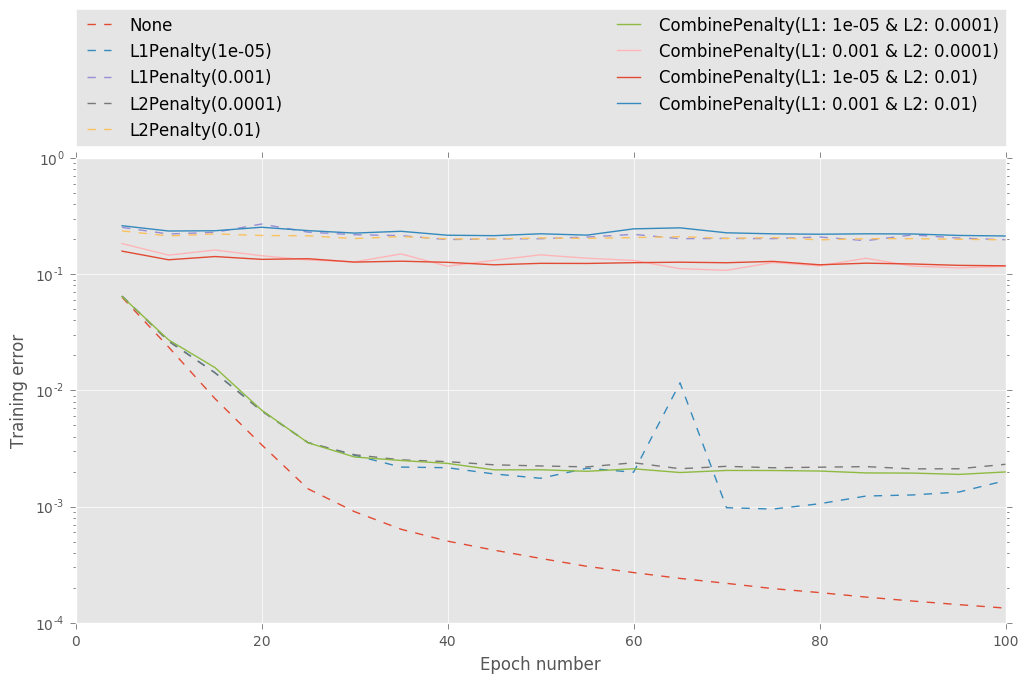

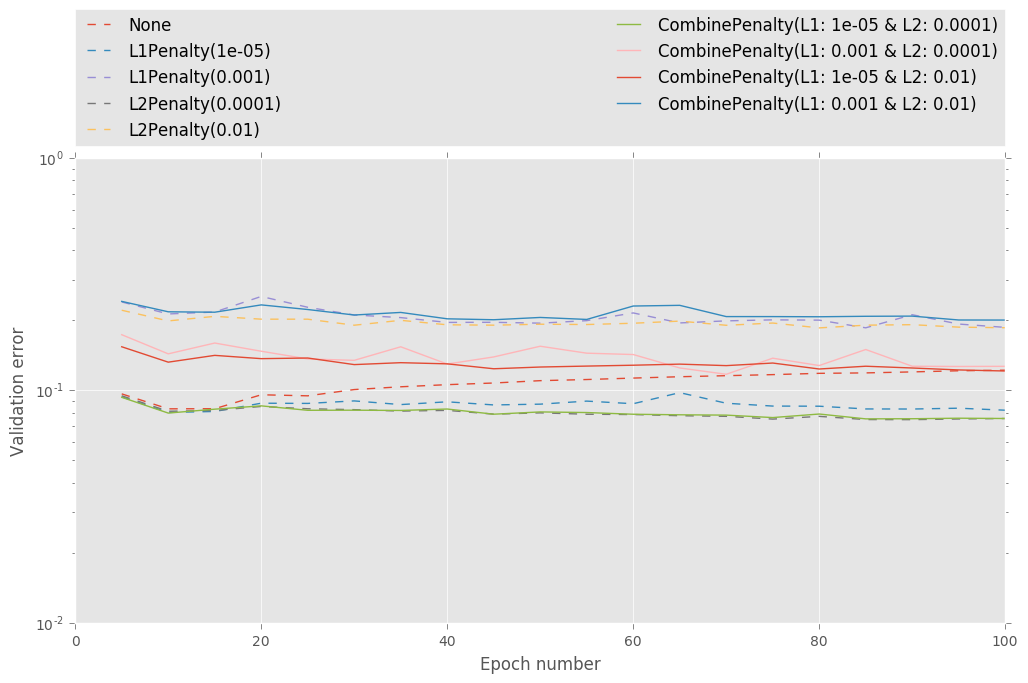

In [66]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

color = ["#F00","#F00","#F00","#F00","#F00","#F00","#F00","#F00","#F00"]

fig_1 = plt.figure(figsize=(12, 6))
fig_2 = plt.figure(figsize=(12, 6))
ax1 = fig_1.add_subplot(1, 1, 1)
ax2 = fig_2.add_subplot(1, 1, 1)
count = 0
for weight_penalty, run in run_info.items():
    stats, keys, run_time = run
    if count >= 5:
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], label=str(weight_penalty))
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], label=str(weight_penalty))
    else:
        ax1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(train)']], '--',label=str(weight_penalty))
        ax2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                 stats[1:, keys['error(valid)']], '--',label=str(weight_penalty))
    count += 1
ax1.legend(bbox_to_anchor=(0., 1.02, 1., 0.3), ncol=2, mode="expand", borderaxespad=0.)
ax1.set_xlabel('Epoch number')
ax1.set_ylabel('Training error')
ax1.set_yscale('log')


ax2.legend(bbox_to_anchor=(0., 1.02, 1., 0.3), ncol=2, mode="expand", borderaxespad=0.)
ax2.set_xlabel('Epoch number')
ax2.set_ylabel('Validation error')
ax2.set_yscale('log')

fig_1.savefig('error_train.png',dpi=200)
fig_2.savefig('error_valid.png',dpi=200)


In [18]:
def plot_param_histogram(param, fig_size=(6, 3), interval=[-1.5, 1.5]):
    """Plots a normalised histogram of an array of parameter values."""
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot(111)
    ax.hist(param.flatten(), 50, interval, normed=True)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('Normalised frequency density')
    return fig, ax

def visualise_first_layer_weights(weights, fig_size=(5, 5)):
    """Plots a grid of first layer weights as feature maps."""
    fig = plt.figure(figsize=fig_size)
    num_feature_maps = weights.shape[0]
    grid_size = int(num_feature_maps**0.5)
    max_abs = np.abs(model.params[0]).max()
    tiled = -np.ones((30 * grid_size, 
                      30 * num_feature_maps // grid_size)) * max_abs
    for i, fm in enumerate(model.params[0]):
        r, c = i % grid_size, i // grid_size
        tiled[1 + r * 30:(r + 1) * 30 - 1, 
              1 + c * 30:(c + 1) * 30 - 1] = fm.reshape((28, 28))
    ax = fig.add_subplot(111)
    max_abs = np.abs(tiled).max()
    ax.imshow(tiled, cmap='Greys', vmin=-max_abs, vmax=max_abs)
    ax.axis('off')
    fig.tight_layout()
    plt.show()
    return fig, ax

Regularisation: None


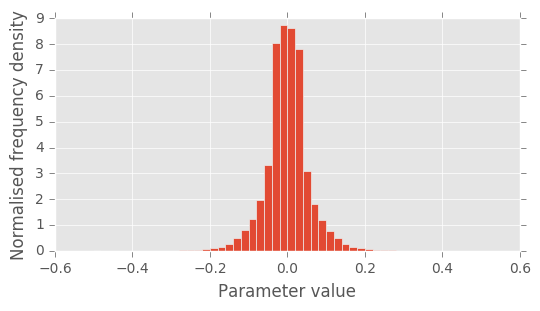

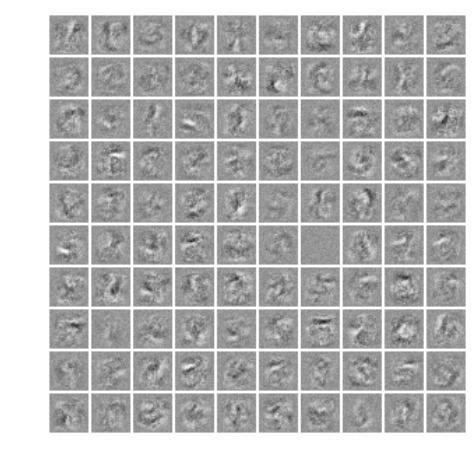

Regularisation: CombinePenalty(L1: 1e-05 & L2: 0.0001)


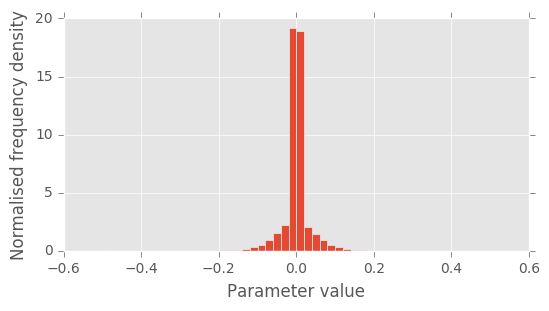

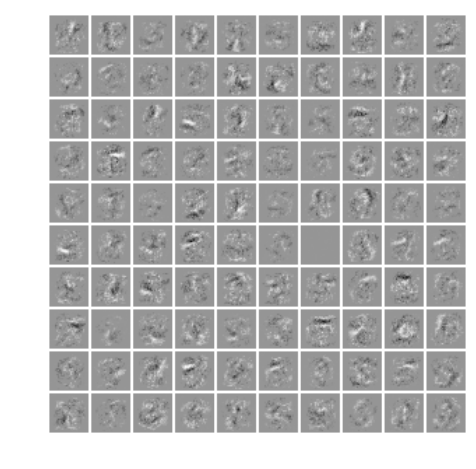

Regularisation: CombinePenalty(L1: 0.001 & L2: 0.0001)


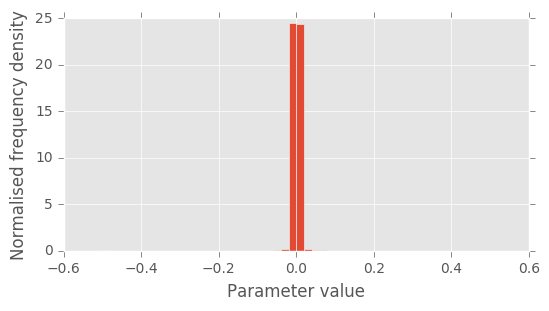

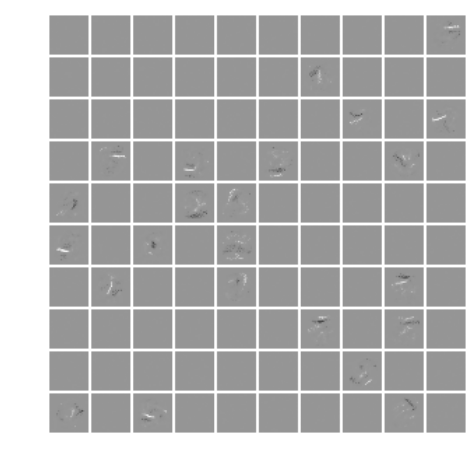

Regularisation: CombinePenalty(L1: 1e-05 & L2: 0.01)


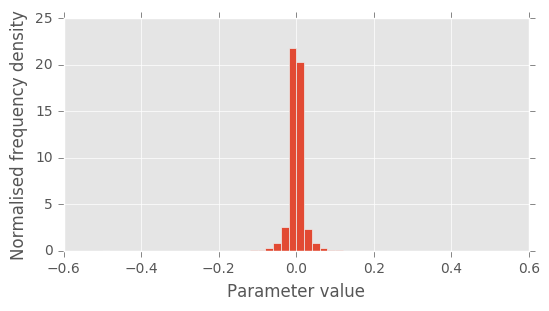

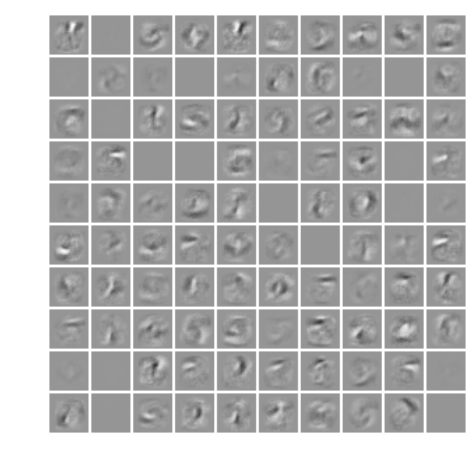

Regularisation: CombinePenalty(L1: 0.001 & L2: 0.01)


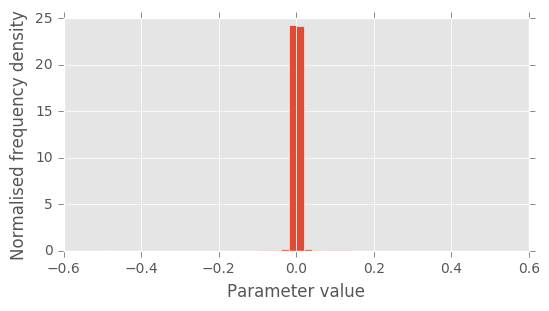

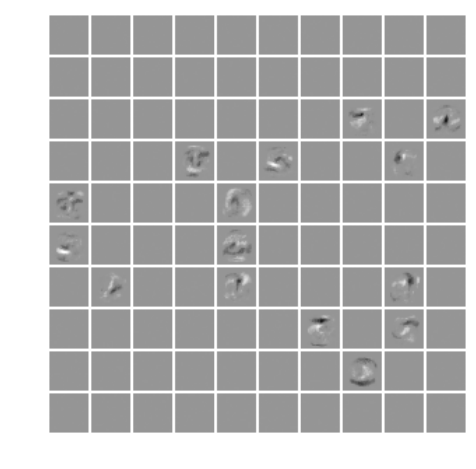

In [19]:
for weight_penalty, model in models.items():
    print('Regularisation: {0}'.format(weight_penalty))
    _ = plot_param_histogram(model.params[0], interval=[-0.5, 0.5])
    _ = visualise_first_layer_weights(model.params[0])